
# Graph Tool for research project on swarm robotics verification.
The tool can be used to generate a UPPAAL neighbour matrix in raw text and show its graph representation using NetworkX.

In [ ]:
#Requisites:
import networkx as nx
import matplotlib.pyplot as plt
import math
import random
import statistics

Generate and draw network:

<ipython-input-13-29156f92d448>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


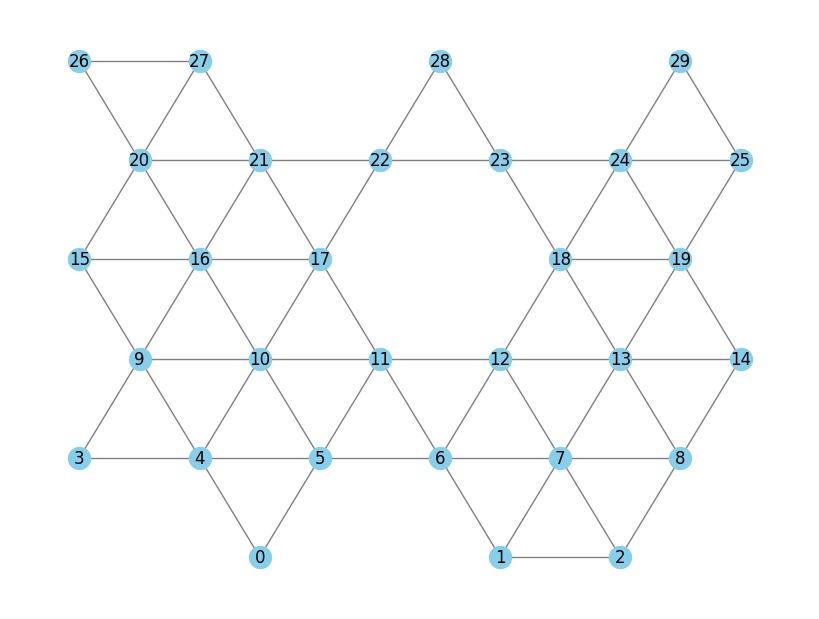

In [ ]:
#Redoing this to make connected triangular lattices with holes
def triangular_lattice(rows, cols):
    G = nx.Graph()
    pos = {}

    for y in range(rows):
        offset = 0.5 if y % 2 == 0 else 0
        for x in range(cols):
            node = (x, y)
            px = x + offset
            pos[node] = (px, y)
            G.add_node(node)

    for (x, y) in G.nodes:
        if (x + 1, y) in G:
            G.add_edge((x, y), (x + 1, y))
        if (x, y + 1) in G:
            G.add_edge((x, y), (x, y + 1))
        if y % 2 == 0:
            if (x + 1, y + 1) in G:
                G.add_edge((x, y), (x + 1, y + 1))
        else:
            if (x - 1, y + 1) in G:
                G.add_edge((x, y), (x - 1, y + 1))

    return G, pos

def add_random_holes(G, pos, num_holes):
    G = G.copy()
    all_nodes = list(G.nodes)
    random.shuffle(all_nodes)
    removed = 0

    for node in all_nodes:
        if removed >= num_holes:
            break
        G_con = G.copy()
        G_con.remove_node(node)
        if nx.is_connected(G_con):
            removed += 1
            G = G_con
    return G

# Parameters
rows, cols = 6, 6
num_holes = 6

# Build full lattice
G_full, pos = triangular_lattice(rows, cols)

# Add holes and create IDs
G_holey = add_random_holes(G_full, pos, num_holes)
id_map = {node: idx for idx, node in enumerate(G_holey.nodes())}

# Draw
plt.figure(figsize=(8, 6))
nx.draw(G_holey, pos={n: pos[n] for n in G_holey.nodes}, labels=id_map, with_labels=True, node_size=250, node_color="skyblue", edge_color="gray")
plt.tight_layout()
plt.show()

Generate UPPAAL input for above network and find network dependency based on algorithm in paper.

In [ ]:
def generate_UPPAAL_input(graph, Q, NN):
    nodes = list(graph.nodes)
    node_to_id = {node: idx for idx, node in enumerate(nodes)}
    R = len(nodes)

    matrix = [[False] * R for _ in range(R)]

    for u, v in graph.edges:
        i = node_to_id[u]
        j = node_to_id[v]
        matrix[i][j] = True
        matrix[j][i] = True

    m = len(graph)
    i = 0
    print(f"//This is a network of {m} robots with {Q} options")
    print(f"const int R = {m};")
    print(f"const int Q = {Q};")
    print(f"const int NN = {NN};")
    print(f"const double empirical = 0.0;")
    #print(f"SEEDP") #FIX AFTER LATEST UPLOAD
    #print(f"SEEDNUM = ") #FIX AFTER LATEST UPLOAD
    print("//Neighbour Matrix")
    print(f"bool C[R][R] = {{", end="")
    for row in matrix:
        i += 1
        line = ", ".join("true" if val else "false" for val in row)
        print(f"  {{{line}}}", end="")
        if (i != len(matrix)):
            print(",")
    print("};")

    return matrix

def MatrixToNetworkX(matrix):
    G = nx.Graph()
    for i in range(len(matrix)):
        G.add_node(i)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i][j]:
                G.add_edge(i, j)
    return G

def GetNetworkDependency(graph):
    S = len(graph)
    G = MatrixToNetworkX(graph)
    D_ind = [ 0 for i in range(S) ]
    for k1 in range(S):
        P = dict(nx.single_source_all_shortest_paths(G, k1))
        for k2, p in P.items():
            D_delta = 1/len(p)
            for i in (range(len(p))):
                for n in range(len(p[i])):
                    if p[i][n] != k1 and p[i][n] != k2:
                        D_ind[p[i][n]] += D_delta
    D_mean = statistics.mean(D_ind)
    D_max = max(D_ind)
    D_rel = D_max/D_mean
    return D_rel, D_ind.index(D_max)


matrix = generate_UPPAAL_input(G_holey, 5, 6)

nd, ni = GetNetworkDependency(matrix)

print(f"//Network dependency: {nd}")
print(f"//Most important node: {ni}")


//This is a network of 30 robots with 5 options
const int R = 30;
const int Q = 5;
const int NN = 6;
const double empirical = 0.0;
//Neighbour Matrix
bool C[R][R] = {  {false, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, false, true, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, true, false, false, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, false, false, false, true, false, false, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, fal

<ipython-input-4-8fa1d4a1b605>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


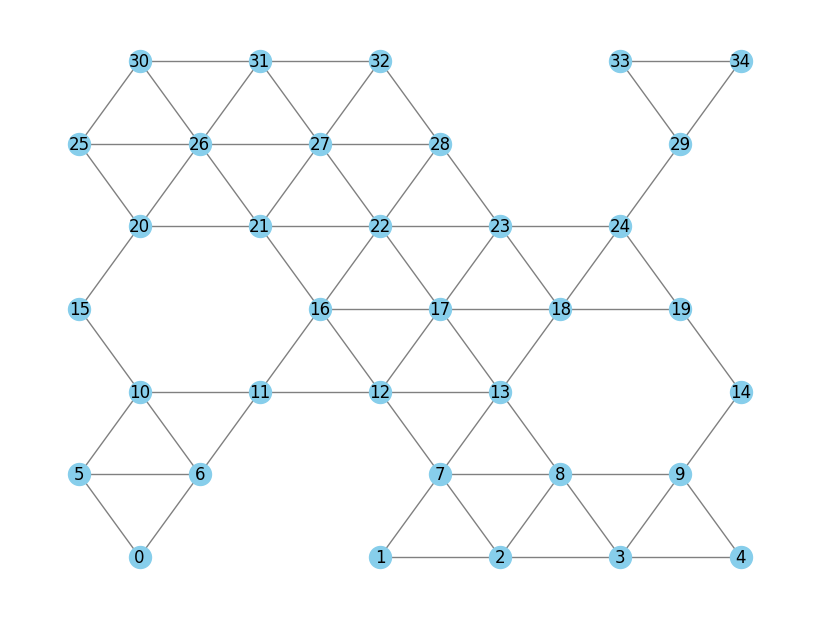

//This is a network of 35 robots with 30 options
const int R = 35;
const int Q = 30;
const int NN = 6;
const double empirical = 0.0;
//Neighbour Matrix
bool C[R][R] = {  {false, false, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, false, true, false, false, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, true, false, true, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, false, true, false, true, false, false, false, true, true, false, false, false, fal

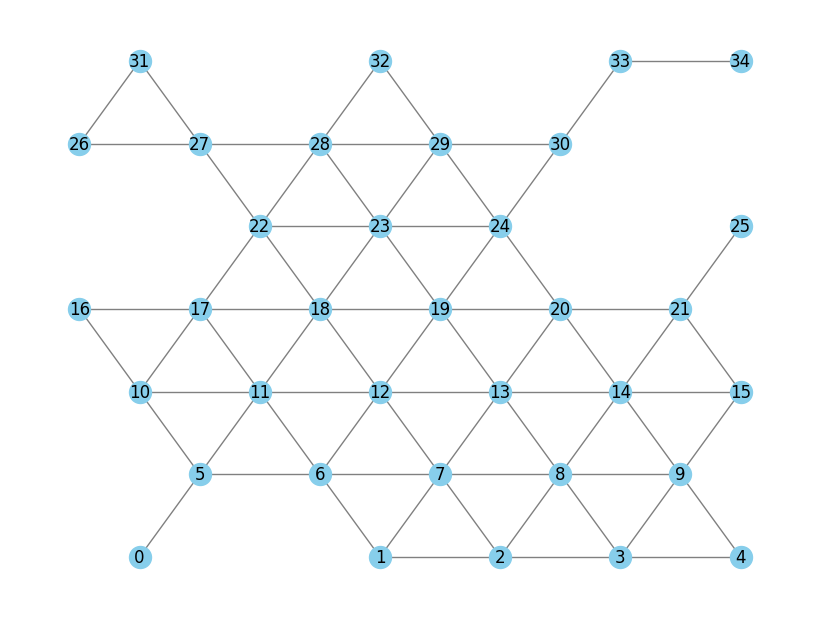

//This is a network of 35 robots with 30 options
const int R = 35;
const int Q = 30;
const int NN = 6;
const double empirical = 0.0;
//Neighbour Matrix
bool C[R][R] = {  {false, false, false, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, false, true, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, true, false, true, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, false, true, false, true, false, false, false, true, true, false, false, false, fal

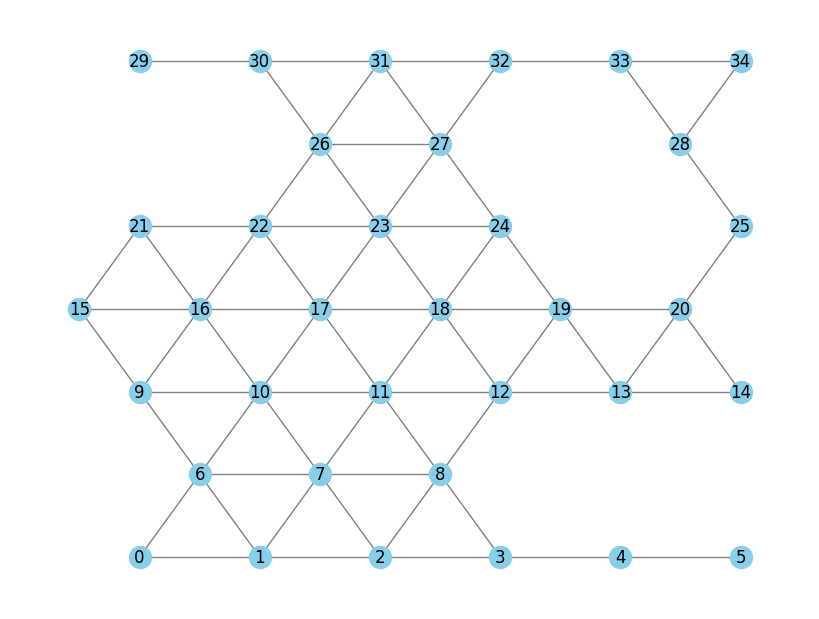

//This is a network of 35 robots with 30 options
const int R = 35;
const int Q = 30;
const int NN = 6;
const double empirical = 0.0;
//Neighbour Matrix
bool C[R][R] = {  {false, true, false, false, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {true, false, true, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, true, false, true, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, false, true, false, true, false, false, false, true, false, false, false, false, fals

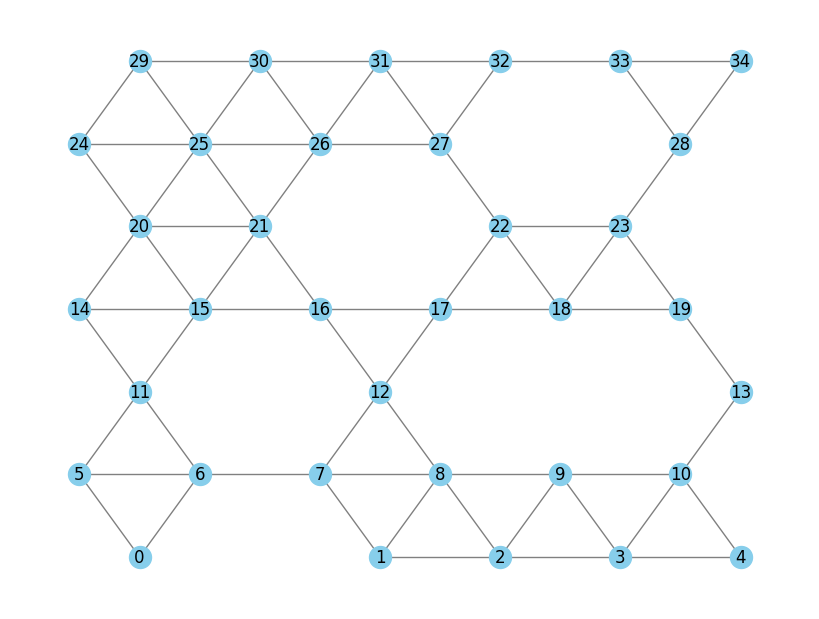

//This is a network of 35 robots with 30 options
const int R = 35;
const int Q = 30;
const int NN = 6;
const double empirical = 0.0;
//Neighbour Matrix
bool C[R][R] = {  {false, false, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, false, true, false, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, true, false, true, false, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false},
  {false, false, true, false, true, false, false, false, false, true, true, false, false, fals

In [ ]:
#FOR FAST GENERATION
nd = 0.0
while (not (nd < 3.1 and nd > 2.9)):
    # Parameters
    rows, cols = 7, 6
    num_holes = 7

    # Build full lattice
    G_full, pos = triangular_lattice(rows, cols)

    # Add holes and create IDs
    G_holey = add_random_holes(G_full, pos, num_holes)
    id_map = {node: idx for idx, node in enumerate(G_holey.nodes())}

    # Draw
    plt.figure(figsize=(8, 6))
    nx.draw(G_holey, pos={n: pos[n] for n in G_holey.nodes}, labels=id_map, with_labels=True, node_size=250, node_color="skyblue", edge_color="gray")
    plt.tight_layout()
    plt.show()

    # Network Dependency and UPPAAL
    matrix = generate_UPPAAL_input(G_holey, 30, 6)
    nd, ni = GetNetworkDependency(matrix)
    print(f"//Network dependency: {nd}")
    print(f"//Most important node: {ni}")


# Visualisation Tools for report

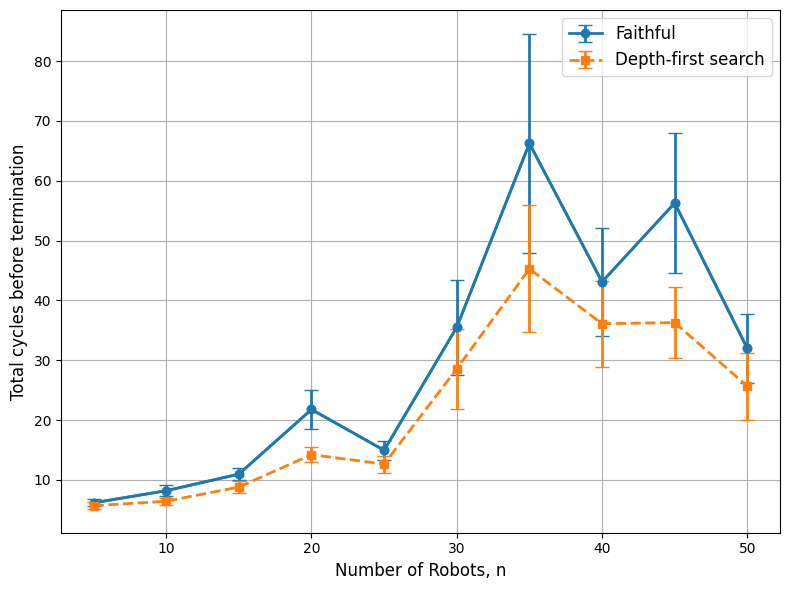

In [ ]:
# Visualisation for report
m_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]  # X
cycle_counts_faithful = [6.19, 8.21, 10.98, 21.79, 14.96, 35.54, 66.25, 43.11, 56.28, 31.99]  # Y1
cycle_counts_dfs = [5.71, 6.45, 8.82, 14.24, 12.67, 28.58, 45.29, 36.11, 36.31, 25.67]  # Y2
std_devs_faithful = [0.61, 0.95, 1.06, 3.3, 1.57, 7.93, 18.32, 9, 11.65, 5.75] # Variance1
std_devs_dfs = [0.55, 0.57, 0.95, 1.21, 1.42, 6.69, 10.63, 7.2, 6, 5.57] # Variance1

# Plot
plt.figure(figsize=(8, 6))
plt.errorbar(m_values, cycle_counts_faithful, yerr=std_devs_faithful, fmt='o-', linewidth=2, capsize=5, label="Faithful")
plt.errorbar(m_values, cycle_counts_dfs, yerr=std_devs_dfs, fmt='s--', linewidth=2, capsize=5, label="Depth-first search")
plt.plot(m_values, cycle_counts_faithful, marker='o', linestyle='-', linewidth=2)


plt.xlabel("Number of Robots, n", fontsize=12)
plt.ylabel("Total cycles before termination", fontsize=12)

plt.grid(True)
plt.legend(fontsize=12)
#plt.xticks(n_values)
#plt.title("Seed Robots vs. Network Dependency", fontsize=14)
plt.tight_layout()


plt.show()

# Legacy

In [ ]:
def Generate(robots_N, max_neighbours, connectivity_percentage):
    neighbour_graph = [ [False]*robots_N for i in range(robots_N) ]
    i = 0
    while i < robots_N:
        r = random.randint(0,100);
        for j in range(robots_N):
             if (r < connectivity_percentage and i != j):
                neighbour_graph[i][j] = True
                neighbour_graph[j][i] = True
                i += 1
                continue
        if neighbour_graph[i].count(True) < 1:
            continue
        i += 1
    i = 0
    while i < robots_N:
        for j in range(robots_N):
            r = random.randint(0,100);
            if (r < connectivity_percentage and neighbour_graph[i].count(True) < max_neighbours and neighbour_graph[j].count(True)< max_neighbours and i != j):
                neighbour_graph[i][j] = True
                neighbour_graph[j][i] = True
        if neighbour_graph[i].count(True) < 1:
            continue
        i += 1
    return neighbour_graph

#Example
g = Generate(16, 6, 50)

In [ ]:
def GetUPPAALInput(Q, NN, graph):
    m = len(graph)
    print(f"//This is a network of {m} robots with {Q} options")
    print(f"const int R = {m};")
    print(f"const int Q = {Q};")
    print(f"const int NN = {NN};")
    print(f"const double empirical = 0.5;")
    print("//Neighbour Matrix")
    print("bool C[R][R] = {", end="")
    for i in range(m):
        print(f"{{{str(graph[i]).lower()[1:-1]}}},")
        print("              ", end = "")
    print("};")

#Example
#g = Generate(10, 6, 50)
Q = 10
NN = 6
GetUPPAALInput(Q, NN, g)

//This is a network of 16 robots with 10 options
const int R = 16;
const int Q = 10;
const int NN = 6;
const double empirical = 0.5;
//Neighbour Matrix
bool C[R][R] = {{false, true, false, true, false, false, false, true, true, true, false, true, false, false, false, false},
              {true, false, true, false, false, true, false, false, false, true, false, false, false, true, true, false},
              {false, true, false, true, false, true, true, true, true, false, false, false, false, false, false, false},
              {true, false, true, false, true, false, false, false, true, true, true, false, false, false, false, false},
              {false, false, false, true, false, true, false, false, true, true, false, true, false, true, false, false},
              {false, true, true, false, true, false, true, true, false, false, true, false, false, false, false, false},
              {false, false, true, false, false, true, false, true, false, false, false, false, true, false, true,

In [ ]:
def GetUPPAALInputAndreasEdition(graph, Q):
    R = len(graph)
    groups = "{"
    for i in range(R):
        groups += f"{{{str(graph[i]).lower()[1:-1]}}}, "

    groups = groups[:-2]
    groups += "}"
    print(f"""
// Place global declarations here.
//dummy variable
clock x;

////TODO:
//Make channels related to prompting (already done a bit, but should be "refined")

////An array for channels to join consensus groups
//First one used by pref_a, next one by pref_b etc.
broadcast chan join[3];

////An array for channels to leave consensus groups
//First one used by pref_a, next one by pref_b etc.
broadcast chan leave[3];

////The number of choices
const int Q = {Q};

////The number of robots
const int R = {R};

////Information regarding neighbours
bool Robots[R][R] = {groups};


///Channels for prompting for updates and receiving them
chan prompt[R];
chan exchange; //Time will tell, whether this one can be simplified away

////Array holding distributions of preferences (a robot should only access its own pref).
int leadingPrefs[R];

////Global values for communication of values through channels (messages):
int N_msg;
double pref_msg[Q];""")


#Example
g = Generate(robots_N=10, max_neighbours=4, connectivity_percentage=30)
GetUPPAALInputAndreasEdition(graph=g, Q=10)


// Place global declarations here.
//dummy variable
clock x;

////TODO:
//Make channels related to prompting (already done a bit, but should be "refined")

////An array for channels to join consensus groups
//First one used by pref_a, next one by pref_b etc.
broadcast chan join[3];

////An array for channels to leave consensus groups
//First one used by pref_a, next one by pref_b etc.
broadcast chan leave[3];

////The number of choices
const int Q = 10;

////The number of robots
const int R = 10;

////Information regarding neighbours
bool Robots[R][R] = {{false, true, true, false, false, false, true, false, false, true}, {true, false, true, false, false, false, true, false, false, true}, {true, true, false, true, false, true, false, false, false, false}, {false, false, true, false, true, false, false, true, false, true}, {false, false, false, true, false, true, false, false, false, false}, {false, false, true, false, true, false, true, false, false, false}, {true, true, false, false, 